## ch05 Stumps on Real Data
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.19</div>
<div style="text-align: right"> Last update: 2023.7.19</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

### 준비

In [2]:
import subprocess
def my_dot_export(xg, num_trees, filename, title='', direction='TB'):
    """Exports a specified number of trees from an XGBoost model as a graph 
    visualization in dot and png formats.

    Args:
        xg: An XGBoost model.
        num_trees: The number of tree to export.
        filename: The name of the file to save the exported visualization.
        title: The title to display on the graph visualization (optional).
        direction: The direction to lay out the graph, either 'TB' (top to 
            bottom) or 'LR' (left to right) (optional).
    """
    res = xgb.to_graphviz(xg, num_trees=num_trees)
    content = f'''    node [fontname = "Roboto Condensed"];
    edge [fontname = "Roboto Thin"];
    label = "{title}"
    fontname = "Roboto Condensed"
    '''
    out = res.source.replace('graph [ rankdir=TB ]', 
                             f'graph [ rankdir={direction} ];\n {content}')
    # dot -Gdpi=300 -Tpng -ocourseflow.png courseflow.dot 
    dot_filename = filename
    with open(dot_filename, 'w') as fout:
        fout.write(out)
    png_filename = dot_filename.replace('.dot', '.png')
    subprocess.run(f'dot -Gdpi=300 -Tpng -o{png_filename} {dot_filename}'.split())

In [3]:
import urllib.request
import zipfile

url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

def extract_zip(src, dst, member_name):
    """Extract a member file from a zip file and read it into a pandas 
    DataFrame.

    Parameters:
        src (str): URL of the zip file to be downloaded and extracted.
        dst (str): Local file path where the zip file will be written.
        member_name (str): Name of the member file inside the zip file 
            to be read into a DataFrame.

    Returns:
        pandas.DataFrame: DataFrame containing the contents of the 
            member file.
    """   
    url = src
    fname = dst
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(dst, mode = 'wb') as fout:
        fout.write(data)
    with zipfile.ZipFile(dst) as z:
        kag = pd.read_csv(z.open(member_name))
        raw = kag.iloc[1:]
        return raw

In [4]:
raw = extract_zip(url, fname, member_name)
raw.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,621,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,-1,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1


In [5]:
raw.shape

(23859, 395)

In [6]:
raw.to_csv("../../data/kaggle-survey-2018/raw.csv", index=False)

In [7]:
raw = pd.read_csv("../../data/kaggle-survey-2018/raw.csv")
raw.shape

(23859, 395)

In [8]:
def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the Kaggle survey data and return a new DataFrame.

    This function takes a Pandas DataFrame containing Kaggle 
    survey data as input and returns a new DataFrame. The 
    modifications include extracting and transforming certain 
    columns, renaming columns, and selecting a subset of columns.

    Parameters
    ----------
    df_ : pd.DataFrame
        The input DataFrame containing Kaggle survey data.

    Returns
    -------
    pd.DataFrame
        The new DataFrame with the modified and selected columns.
    """  
    return (df_
            .assign(age = df_.Q2.str.slice(0, 2).astype(int),
                    education = df_.Q4.replace({
                        'Master’s degree': 18,
                        'Bachelor’s degree': 16,
                        'Doctoral degree': 20,
                        'Some college/university study without earning a bachelor’s degree': 13,
                        'Professional degree': 19,
                        'I prefer not to answer': None,
                        'No formal education past high school': 12}),
                    major = (df_.Q5
                             .pipe(topn, n = 3)
                             .replace({
                                 'Computer science (software engineering, etc.)': 'cs',
                                 'Engineering (non-computer focused)': 'eng',
                                 'Mathematics or statistics': 'stat'})
                             ),
                    years_exp = (df_.Q8.str.replace('+', '', regex=False)
                                 .str.split('-', expand=True)
                                 .iloc[:, 0]
                                 .astype(float)),
                    compensation=(df_.Q9.str.replace('+','', regex=False)
                           .str.replace(',','', regex=False)
                           .str.replace('500000', '500', regex=False)
                           .str.replace('I do not wish to disclose my approximate yearly compensation',
                                        '0', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .fillna(0)
                           .astype(int)
                           .mul(1_000)),
                    python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
                    r=df_.Q16_Part_2.fillna(0).replace('R', 1),
                    sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
               )#assign
            .rename(columns=lambda col: col.replace(' ', '_'))
            .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,'
                 'python,r,sql'.split(',')]
            )

In [9]:
def topn(ser, n=5, default='other'):
    """
    Replace all values in a Pandas Series that are not among 
    the top `n` most frequent values with a default value.

    This function takes a Pandas Series and returns a new 
    Series with the values replaced as described above. The 
    top `n` most frequent values are determined using the 
    `value_counts` method of the input Series.

    Parameters
    ----------
    ser : pd.Series
        The input Series.
    n : int, optional
        The number of most frequent values to keep. The 
        default value is 5.
    default : str, optional
        The default value to use for values that are not among 
        the top `n` most frequent values. The default value is 
        'other'.

    Returns
    -------
    pd.Series
        The modified Series with the values replaced.
    """    
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

In [10]:
from feature_engine import encoding, imputation
from sklearn import base, pipeline

In [11]:
class TweakKagTransformer(base.BaseEstimator,
    base.TransformerMixin):
    """
    A transformer for tweaking Kaggle survey data.

    This transformer takes a Pandas DataFrame containing 
    Kaggle survey data as input and returns a new version of 
    the DataFrame. The modifications include extracting and 
    transforming certain columns, renaming columns, and 
    selecting a subset of columns.

    Parameters
    ----------
    ycol : str, optional
        The name of the column to be used as the target variable. 
        If not specified, the target variable will not be set.

    Attributes
    ----------
    ycol : str
        The name of the column to be used as the target variable.
    """

    def __init__(self, ycol=None):
        self.ycol = ycol

    def transform(self, X):
        return tweak_kag(X)

    def fit(self, X, y=None):
        return self

In [12]:
def get_rawX_y(df, y_col):
    raw = (df
            .query('Q3.isin(["United States of America", "China", "India"]) '
               'and Q6.isin(["Data Scientist", "Software Engineer"])')
          )
    return raw.drop(columns=[y_col]), raw[y_col]

In [13]:
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
                                       variables=['Q1', 'Q3', 'major'])),
     ('num_inpute', imputation.MeanMedianImputer(imputation_method='median',
                                                    variables=['education', 'years_exp']))]
) 

In [14]:
from sklearn import model_selection

In [15]:
kag_X, kag_y = get_rawX_y(raw, 'Q6')

In [16]:
kag_X_train, kag_X_test, kag_y_train, kag_y_test = model_selection.train_test_split(
    kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [17]:
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)
X_test = kag_pl.transform(kag_X_test)

### 5.1 Scikit-learn stump on read data

stump가 우리에게 알려주는 부분을 생각해보자.  
첫번째 분할 은 데이터로 클래스를 가장 잘 분리하는 값이므로 가장 중요한 피처 중 하나를 포함해야한다.   
정보가 하나만 있는 경우, 그루터기가 분할하는 열을 원할 것입니다.


In [18]:
from sklearn import tree

In [19]:
stump_dt = tree.DecisionTreeClassifier(max_depth=1)
X_train = kag_pl.fit_transform(kag_X_train)
stump_dt.fit(X_train, kag_y_train)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]\nclass = Data Scientist'),
 Text(0.25, 0.25, 'gini = 0.493\nsamples = 1484\nvalue = [653, 831]\nclass = Software Engineer'),
 Text(0.75, 0.25, 'gini = 0.322\nsamples = 626\nvalue = [500, 126]\nclass = Data Scientist')]

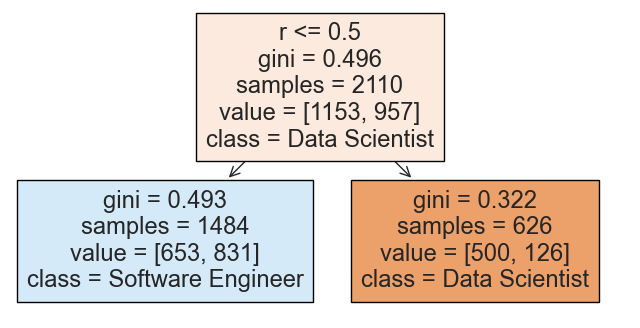

In [20]:
fig, ax = plt.subplots(figsize = (8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(stump_dt, feature_names=features,
               filled=True, 
               class_names=stump_dt.classes_,
               ax = ax)

In [21]:
X_test= kag_pl.transform(kag_X_test)
stump_dt.score(X_test, kag_y_test)

0.6243093922651933

모델 베이스라인을 만들어보자.

In [22]:
from sklearn import dummy

dummy_model = dummy.DummyClassifier()
dummy_model.fit(X_train, kag_y_train)
dummy_model.score(X_test, kag_y_test)

0.5458563535911602

### 5.2 Decision Stump with XGBoost

XGBoost는 지니 계산을 사용하여 의사 결정 방법을 결정하지 않습니다.  
대신 XGBoost는 부스팅과 그라디언트 디센트를 사용합니다.  
부스팅은 모델을 사용하고 다른 모델과 결합하여 결과를 개선하는 것입니다.  
사실 XGBoost는 익스트림 그래디언트 부스팅의 약자입니다.  
"극단적"이라는 부분은 결과를 정규화하는 기능과 모델을 효율적으로 생성하기 위해 다양한 최적화가 필요하기 때문입니다.

이 경우 후속 모델은 오차를 줄이기 위해 이전 모델의 오차로부터 학습됩니다.  
'경사 하강' 부분은 이 오차를 최소화하는 과정을 목적 함수로 지정해 경사 하강 알고리즘을 적용할 수 있도록 하기 위해 들어갑니다.  
결과는 예측에 대한 오차의 기울기에 따라 결정됩니다.  
목적 함수는 훈련 손실과 정규화 용어의 두 부분을 결합합니다. 

트리는 음의 기울기 방향으로 작은 단계씩 이동하는 특징을 분할하여 생성되며, 이는 손실 함수의 전역 최소값에 더 가깝게 이동합니다.

XGBoost를 제어하는 데는 많은 파라미터가 있습니다.  
그중 하나가 나무의 수인 n_estimators입니다.  
이 값을 1로 설정하여 XGBoost로 stump를 생성하고, 이것이 사이킷런 스텀프와 비슷한 성능을 보이는지 살펴보겠습니다.

In [23]:
import xgboost as xgb

In [24]:
kag_stump = xgb.XGBClassifier(n_estimators = 1, max_depth = 1)
kag_stump.fit(X_train, kag_y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['Data Scientist' 'Software Engineer']

- 에러가 발생했다.  
- 사이킷런과 달리 xgboost는 문자열 레이블이 지원되지 않는다.

In [25]:
kag_y_train.head()

586      Software Engineer
3064        Data Scientist
8434        Data Scientist
3109        Data Scientist
16371    Software Engineer
Name: Q6, dtype: object

In [26]:
kag_y_train.value_counts()

Q6
Data Scientist       1153
Software Engineer     957
Name: count, dtype: int64

변환을 하는 방법은 두가지가 있다.  
- True, False를 사용하는 방법

In [27]:
print(kag_y_train == "Software Engineer")

586       True
3064     False
8434     False
3109     False
16371     True
         ...  
16607     True
7324      True
21809    False
4916     False
638      False
Name: Q6, Length: 2110, dtype: bool


또다른 방법은 label encoder를 사용하는 방법이다.

In [28]:
from sklearn import preprocessing

In [29]:
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

In [30]:
y_test

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,

In [31]:
label_encoder.classes_

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [32]:
label_encoder.inverse_transform([0, 1])

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [33]:
kag_stump = xgb.XGBClassifier(n_estimators = 1, max_depth = 1)
kag_stump.fit(X_train, y_train)
kag_stump.score(X_test, y_test)

0.6243093922651933

In [34]:
my_dot_export(kag_stump, num_trees=0, filename='stump_xg_kag.dot',
title='XGBoost Stump')


(process:38826): Pango-WARNING **: 09:23:40.121: couldn't load font "Roboto Condensed Not-Rotated 14", modified variant/weight/stretch as fallback, expect ugly output.


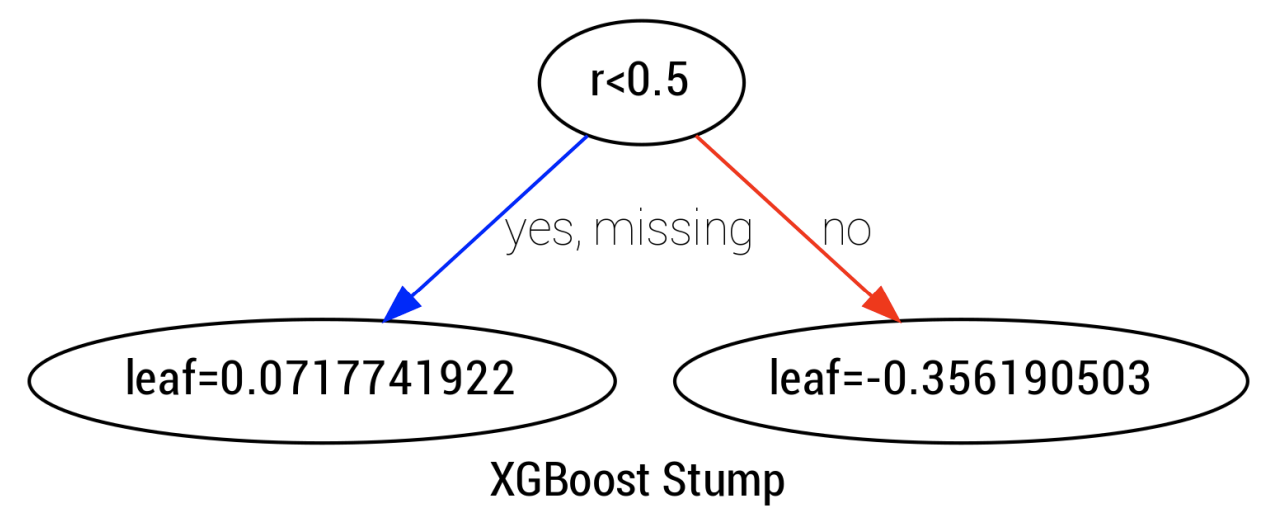

### 5.3 Values in the XGBoost Tree

export의 leaves에 있는 숫자는 확률이다. 실제는 로그 값이다. 이것을 로짓이라고 부른다.   

트리 노드에서 나온 값으로 역 로짓을 계산하면 예측확률을 얻는다.   

설문조사 응답자가 R 언어를 사용하지 않는 경우 리프 값은 .0717741922입니다. 이 값의 역로짓은 .518, 즉 51.8%입니다. 이 값이 0.5보다 크므로 양수 레이블 또는 클래스인 소프트웨어 엔지니어로 가정합니다(라벨 인코더에서 소프트웨어 엔지니어의 값으로 사용한 kag_stump.classes_의 두 번째 값은 1입니다)

In [35]:
kag_stump.classes_

array([0, 1])

In [36]:
def inv_logit(p: float) -> float:
    """
    Compute the inverse logit function of a given value.

    The inverse logit function is defined as:
        f(p) = exp(p) / (1 + exp(p))

    Parameters
    ----------
    p : float
        The input value to the inverse logit function.

    Returns
    -------
    float
        The output of the inverse logit function.
    """
    return np.exp(p) / (1 + np.exp(p))

In [37]:
inv_logit(.0717741922)

0.5179358489487103

In [38]:
inv_logit(-.3592)

0.41115323716754393

이제 inverse logit function을 그려보자.

Text(-3, 0.4, 'Predict Negative')

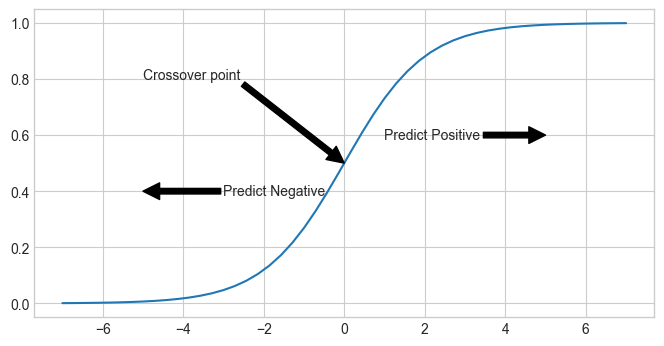

In [39]:
fig, ax = plt.subplots(figsize  = (8, 4))
vals = np.linspace(-7, 7)

ax.plot(vals, inv_logit(vals))
ax.annotate('Crossover point', (0,.5), (-5,.8), arrowprops={'color':'k'})
ax.annotate('Predict Positive', (5,.6), (1,.6), va='center', arrowprops={'color':'k'})
ax.annotate('Predict Negative', (-5,.4), (-3,.4), va='center', arrowprops={'color':'k'})